In [1]:
import pandas as pd
from prog.model import * 
from prog.tools import *
from tqdm import tqdm
import warnings, pickle, time, os
warnings.filterwarnings("ignore")

shuffle = True
random_state = None
limit_end = 30
top_score = 3
test_size = 0.15
model_boundary = 0.5
minute = 10
stop = minute * 60

In [2]:
input_ = {
    "model_id": "20230807120000000",
}
model_id = input_["model_id"]

In [3]:
root = r"C:\Users\tzuli\Documents\python\teco"

# 取得train位置
train_path = os.path.join(root, "data", "train")        
os.makedirs(train_path, exist_ok = True)
data_csv = os.path.join(train_path, "train_data.csv")
output_json = os.path.join(train_path, "output.json")


# 取得model位置
model_path = os.path.join(root, "data", "train", model_id)
os.makedirs(model_path, exist_ok = True)

model_detail = os.path.join(model_path, "model")
os.makedirs(model_detail, exist_ok = True)

In [4]:
df = pd.read_csv(data_csv)
print(df.shape)
df.head(3)

(278, 16)


,日期,工號,序號,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量
0,2023-06-01,FC236606T1-2,1,590,12.0,266.0,259.0,181.0,12.0,275.0,259.0,180.0,358.0,58.20,293.0,23.00
1,2023-06-01,FC236606T1-2,2,590,358.0,58.2,293.0,23.0,358.0,60.0,293.0,23.0,307.0,3.50,241.0,3.90
2,2023-06-01,FC236606T1-2,3,590,307.0,3.5,241.0,3.9,307.0,4.0,241.0,4.0,322.0,0.46,214.0,0.36


##### 刪除缺失值

In [5]:
df = df.dropna().reset_index(drop = True)
df.shape

(190, 16)

##### 刪除特徵

In [6]:
df = df.drop(['日期', '工號', '序號'], axis = 1)
df.head(3)

,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量
0,590,12.0,266.0,259.0,181.0,12.0,275.0,259.0,180.0,358.0,58.20,293.0,23.00
1,590,358.0,58.2,293.0,23.0,358.0,60.0,293.0,23.0,307.0,3.50,241.0,3.90
2,590,307.0,3.5,241.0,3.9,307.0,4.0,241.0,4.0,322.0,0.46,214.0,0.36


#### 預期結果

In [7]:
df = generate_feature(df)
df.head(3)

,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量,預期_F側不平衡量,預期_L側不平衡量,初始_不平衡量_diff,平衡_不平衡量_diff,初始_角度_diff,平衡_角度_diff
0,590,12.0,266.0,259.0,181.0,12.0,275.0,259.0,180.0,358.0,58.20,293.0,23.00,1.0,-9.0,85.0,95.0,113.0,113.0
1,590,358.0,58.2,293.0,23.0,358.0,60.0,293.0,23.0,307.0,3.50,241.0,3.90,0.0,-1.8,35.2,37.0,65.0,65.0
2,590,307.0,3.5,241.0,3.9,307.0,4.0,241.0,4.0,322.0,0.46,214.0,0.36,-0.1,-0.5,0.4,0.0,66.0,66.0


##### Split

In [8]:
target_vol = ["最終_L側不平衡量", "最終_F側不平衡量"]
target_angle = ["最終_L側角度", "最終_F側角度"]
features = df.columns.drop(target_vol + target_angle).to_list()
features

['平衡轉速',
 '初始_L側角度',
 '初始_L側不平衡量',
 '初始_F側角度',
 '初始_F側不平衡量',
 '平衡_L側角度',
 '平衡_L側配重',
 '平衡_F側角度',
 '平衡_F側配重',
 '預期_F側不平衡量',
 '預期_L側不平衡量',
 '初始_不平衡量_diff',
 '平衡_不平衡量_diff',
 '初始_角度_diff',
 '平衡_角度_diff']

In [9]:
l_df = df[df[target_vol[0]] <= limit_end].reset_index(drop = True)
f_df = df[df[target_vol[1]] <= limit_end].reset_index(drop = True)

print(f"df: {len(df)}, l_df: {len(l_df)}, f_df: {len(f_df)}")

df: 190, l_df: 175, f_df: 176


l_df = l_df.drop(["最終_L側角度", "最終_F側角度", "最終_F側不平衡量"], axis = 1)
f_df = f_df.drop(["最終_L側角度", "最終_F側角度", "最終_L側不平衡量"], axis = 1)

l_df.to_csv(r"C:\Users\tzuli\Documents\python\teco\data\raw\musesai\l_df.csv", index = False)
f_df.to_csv(r"C:\Users\tzuli\Documents\python\teco\data\raw\musesai\f_df.csv", index = False)

### L測預測

In [10]:
side = "L"
total_scores = pd.DataFrame()
total_models = {}
preds = {}
num = 8 # 989
start, end = time.time(), time.time()

pbar = tqdm(total = stop, ncols = 150)
while (end - start) < stop:
    end = time.time()
    train, test = split_data(l_df, test_size, shuffle, random_state = num)
    train, test, outlier_boundary = deal_with_outlier(features, train, test)
    train, test, skew_feat, pt = deal_with_skew(features, train, test)
    train, test, scaler = scaling(features, train, test)

    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target_vol[0]], test[target_vol[0]]

    models = modeling(X_train, y_train, random_state = num)

    scores0, pred_trains, pred_tests = calculate_score(models, X_train, X_test, y_train, y_test, scoring = "r2", cv_flag = 1, cv_scoring = "r2", random_state = num)
    scores = scores0.sort_values(("r2", "test"), ascending = False).iloc[[0]]


    if ((scores["r2"] > model_boundary).values.all()) and (scores.iloc[0][('r2',  'test')] < 0.9):
        preds[num] = {"train": pred_trains, "test": pred_tests}
        total_models[num] = models[scores.index[0]]
        scores["order"] = num
        total_scores = pd.concat([total_scores, scores])
    
    num += 1
    mid = end
    end = time.time()
    pbar.update(round(end - mid, 4))

    break

pbar.close()

  0%|                                                                                                            | 0.5491/600 [00:00<10:00,  1.00s/it]


In [11]:
total_scores = total_scores[(total_scores[('r2',  'train')] > 0.7) & (total_scores[('r2',  'test')] > 0.85)]

In [12]:
total_scores = total_scores.sort_values([('r2',  'test'), ('r2',  'train'), ('r2',  'cv')], ascending = False)
total_scores.head(3)

mse        rmse        mape          r2             order
                train  test train  test train  test train  test    cv      
Neural Network  10.25  4.33   3.2  2.08  0.85  1.33  0.78  0.87  0.72     8

In [13]:
best_order = total_scores["order"].iloc[0]
best_score = total_scores.iloc[[0]]
best_score = best_score.drop("order", axis = 1)
best_score.to_csv(os.path.join(model_path, f"{side}_score.csv"))
model = total_models[best_order]
print(best_order)
best_score

8


mse        rmse        mape          r2            
                train  test train  test train  test train  test    cv
Neural Network  10.25  4.33   3.2  2.08  0.85  1.33  0.78  0.87  0.72

In [14]:
pickle.dump(features, open(os.path.join(model_detail, "feat_order.pkl"), "wb"))
pickle.dump(outlier_boundary, open(os.path.join(model_detail, f"{side}_outlier_boundary.pkl"), "wb"))
pickle.dump(skew_feat, open(os.path.join(model_detail, f"{side}_skew_feat.pkl"), "wb"))
pickle.dump(pt, open(os.path.join(model_detail, f"{side}_power_tf.pkl"), "wb"))
pickle.dump(scaler, open(os.path.join(model_detail, f"{side}_scaler.pkl"), "wb"))
pickle.dump(model, open(os.path.join(model_detail, f"{side}_model.pkl"), "wb"))

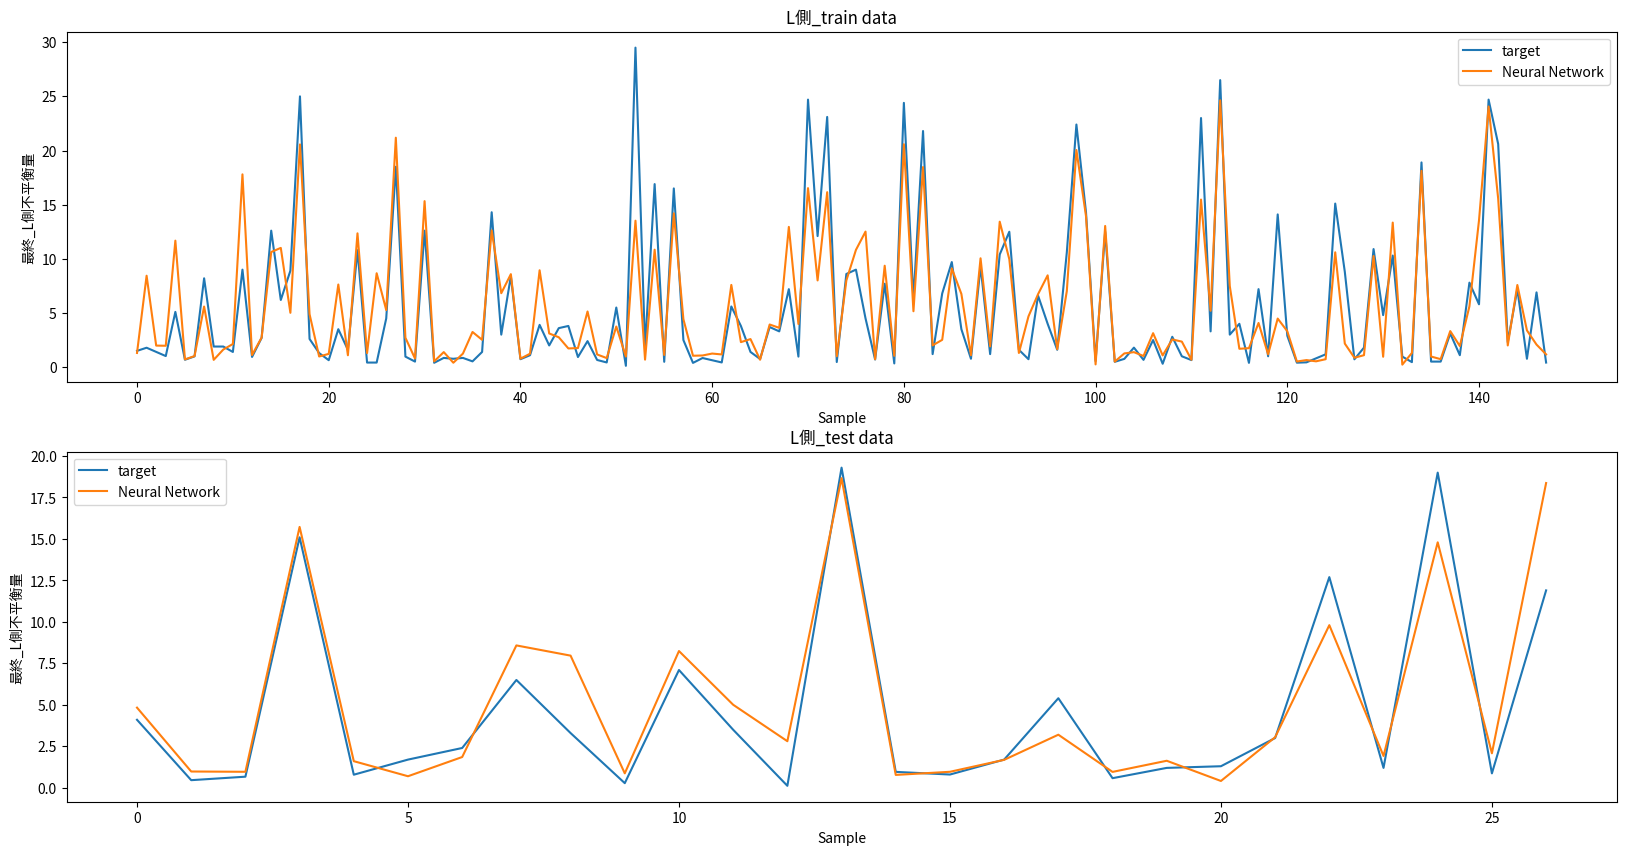

In [15]:
pred_trains, pred_tests = preds[best_order]["train"], preds[best_order]["test"]
pred_plot(pred_trains, pred_tests, best_score, target_vol, model_path, side, top_score = 3)

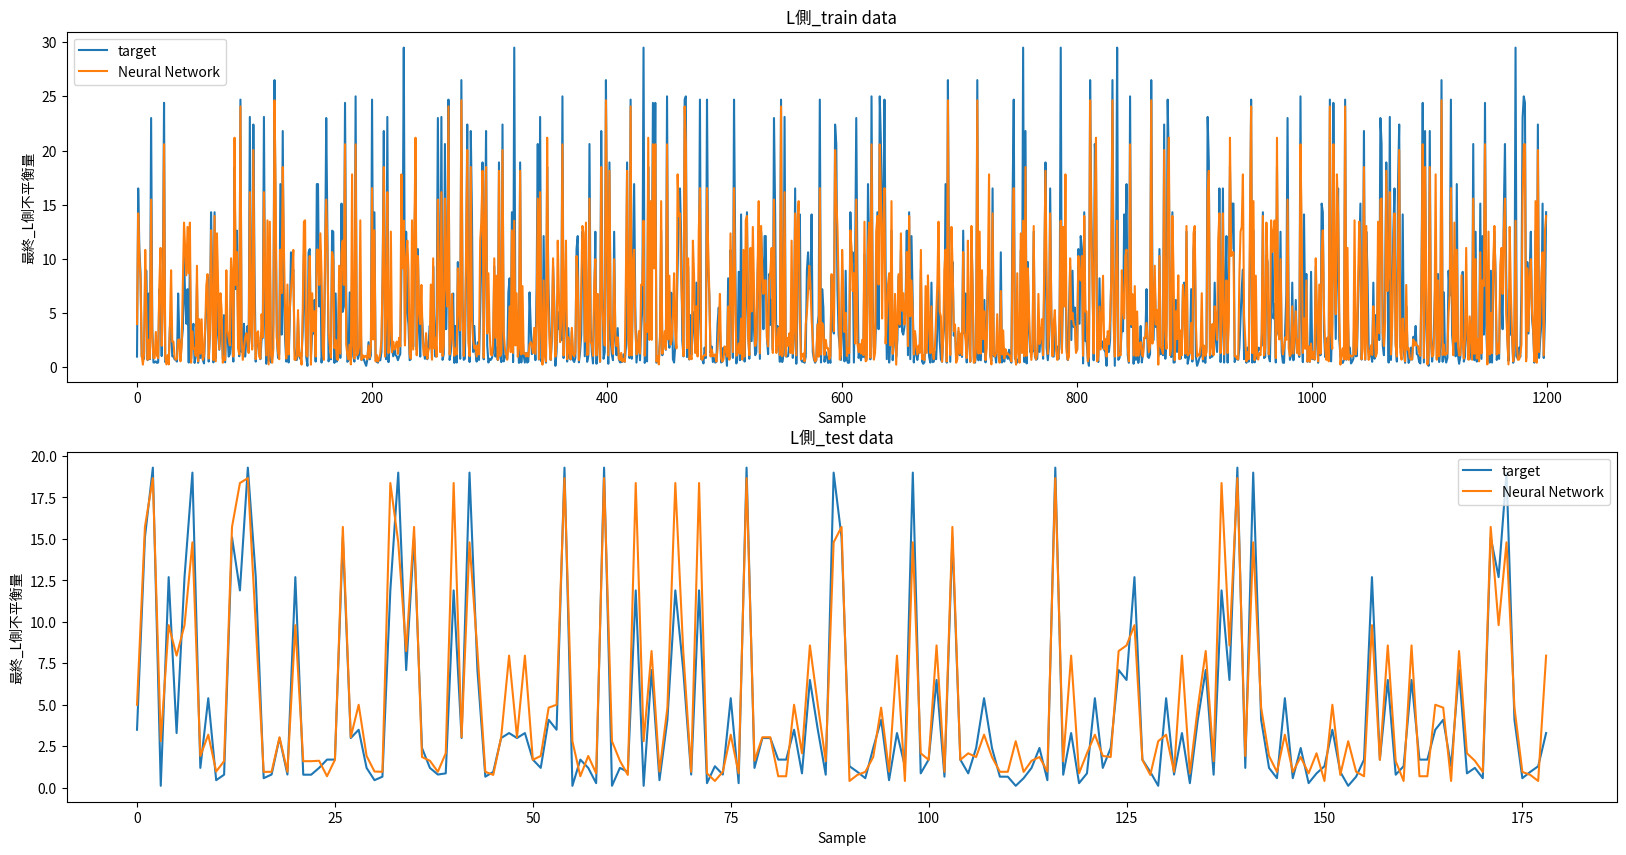

In [16]:
pred_trains_clone = pd.DataFrame()
pred_test_clone = pd.DataFrame()
for _ in range(9):
    pred_trains_clone = pd.concat([pred_trains_clone, pred_trains], ignore_index = True)
for _ in range(7):
    pred_test_clone = pd.concat([pred_test_clone, pred_tests], ignore_index = True)
pred_trains_clone = pred_trains_clone.sample(1200, random_state = random_state).reset_index(drop = True)
pred_test_clone = pred_test_clone.sample(179, random_state = random_state).reset_index(drop = True)
pred_plot(pred_trains_clone, pred_test_clone, best_score, target_vol, model_path, side, top_score = 3)

### F測預測

In [17]:
side = "F"
total_scores = pd.DataFrame()
total_models = {}
preds = {}
num = 681#, 182, 82
start, end = time.time(), time.time()

pbar = tqdm(total = stop, ncols = 150)
while (end - start) < stop:
    end = time.time()
    train, test = split_data(f_df, test_size, shuffle, random_state = num)
    train, test, outlier_boundary = deal_with_outlier(features, train, test)
    train, test, skew_feat, pt = deal_with_skew(features, train, test)
    train, test, scaler = scaling(features, train, test)

    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target_vol[0]], test[target_vol[0]]

    models = modeling(X_train, y_train, random_state = num)

    scores0, pred_trains, pred_tests = calculate_score(models, X_train, X_test, y_train, y_test, scoring = "r2", cv_flag = 1, cv_scoring = "r2", random_state = num)
    scores = scores0.sort_values(("r2", "test"), ascending = False).iloc[[0]]


    if (scores["r2"] > model_boundary).values.all():
        preds[num] = {"train": pred_trains, "test": pred_tests}
        total_models[num] = models[scores.index[0]]
        scores["order"] = num
        total_scores = pd.concat([total_scores, scores])
    
    num += 1
    mid = end
    end = time.time()
    pbar.update(round(end - mid, 4))

    break

pbar.close()

  0%|                                                                                                            | 0.5186/600 [00:00<10:01,  1.00s/it]


In [18]:
total_scores = total_scores[(total_scores[('r2',  'train')] > 0.6) & (total_scores[('r2',  'test')] >= 0.85)]

In [19]:
total_scores = total_scores.sort_values([('r2',  'test'), ('r2',  'train'), ('r2',  'cv')], ascending = False)
total_scores.head(3)

mse        rmse        mape          r2             order
                train  test train  test train  test train  test    cv      
Neural Network  67.81  6.34  8.23  2.52  1.39  0.77  0.63  0.85  0.62   681

In [20]:
best_order = total_scores["order"].iloc[0]
best_score = total_scores.iloc[[0]]
best_score = best_score.drop("order", axis = 1)
best_score.to_csv(os.path.join(model_path, f"{side}_score.csv"))
model = total_models[best_order]
print(best_order)
best_score

681


mse        rmse        mape          r2            
                train  test train  test train  test train  test    cv
Neural Network  67.81  6.34  8.23  2.52  1.39  0.77  0.63  0.85  0.62

In [21]:
pickle.dump(features, open(os.path.join(model_detail, "feat_order.pkl"), "wb"))
pickle.dump(outlier_boundary, open(os.path.join(model_detail, f"{side}_outlier_boundary.pkl"), "wb"))
pickle.dump(skew_feat, open(os.path.join(model_detail, f"{side}_skew_feat.pkl"), "wb"))
pickle.dump(pt, open(os.path.join(model_detail, f"{side}_power_tf.pkl"), "wb"))
pickle.dump(scaler, open(os.path.join(model_detail, f"{side}_scaler.pkl"), "wb"))
pickle.dump(model, open(os.path.join(model_detail, f"{side}_model.pkl"), "wb"))

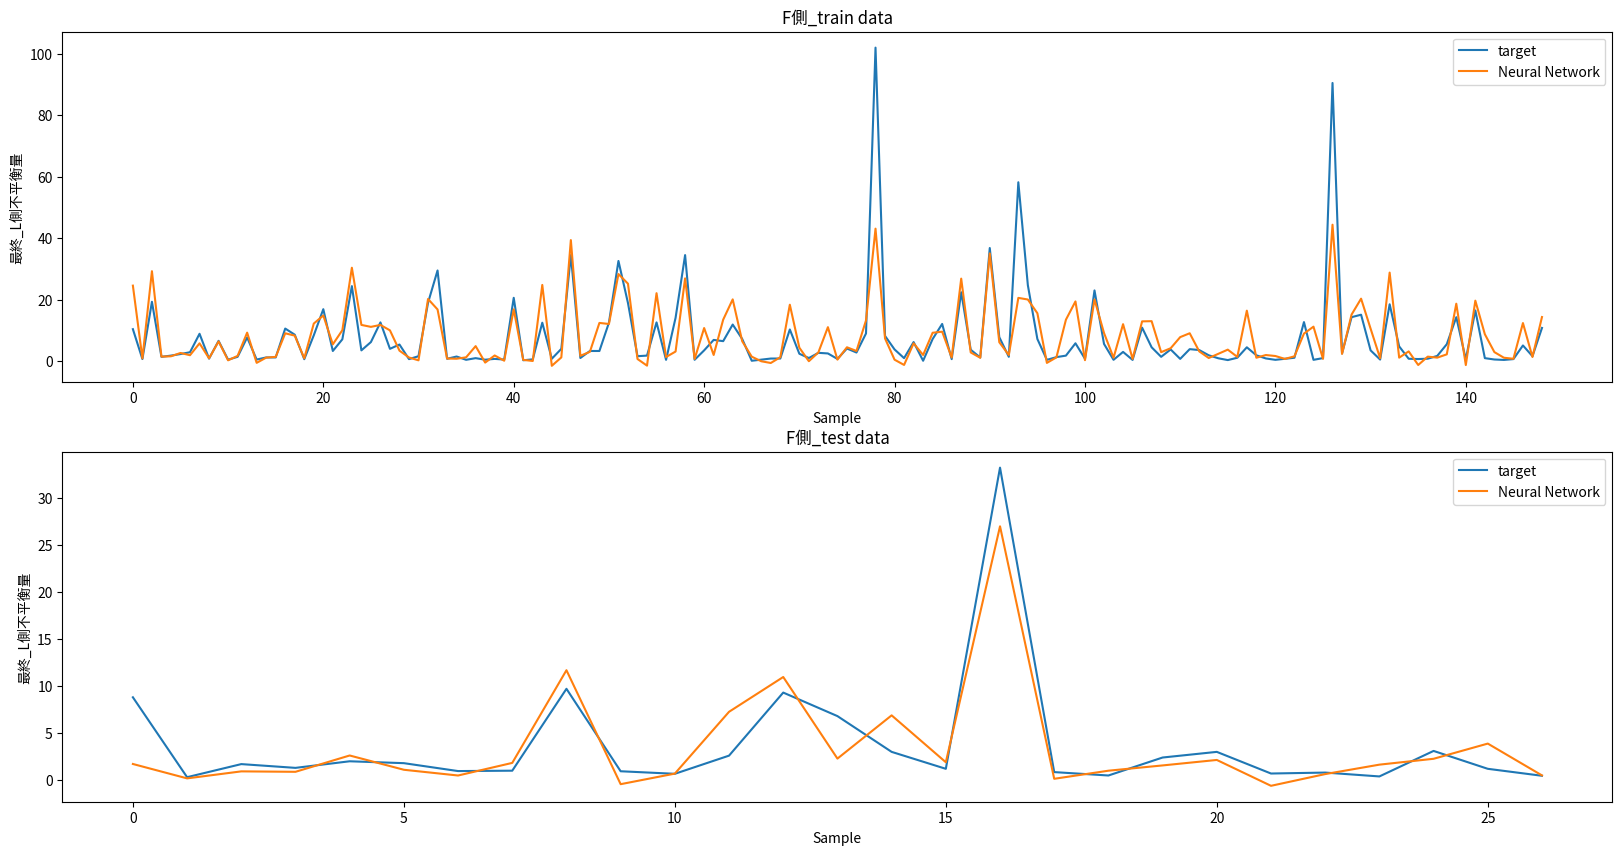

In [22]:
pred_trains, pred_tests = preds[best_order]["train"], preds[best_order]["test"]
pred_plot(pred_trains, pred_tests, best_score, target_vol, model_path, side, top_score = 3)

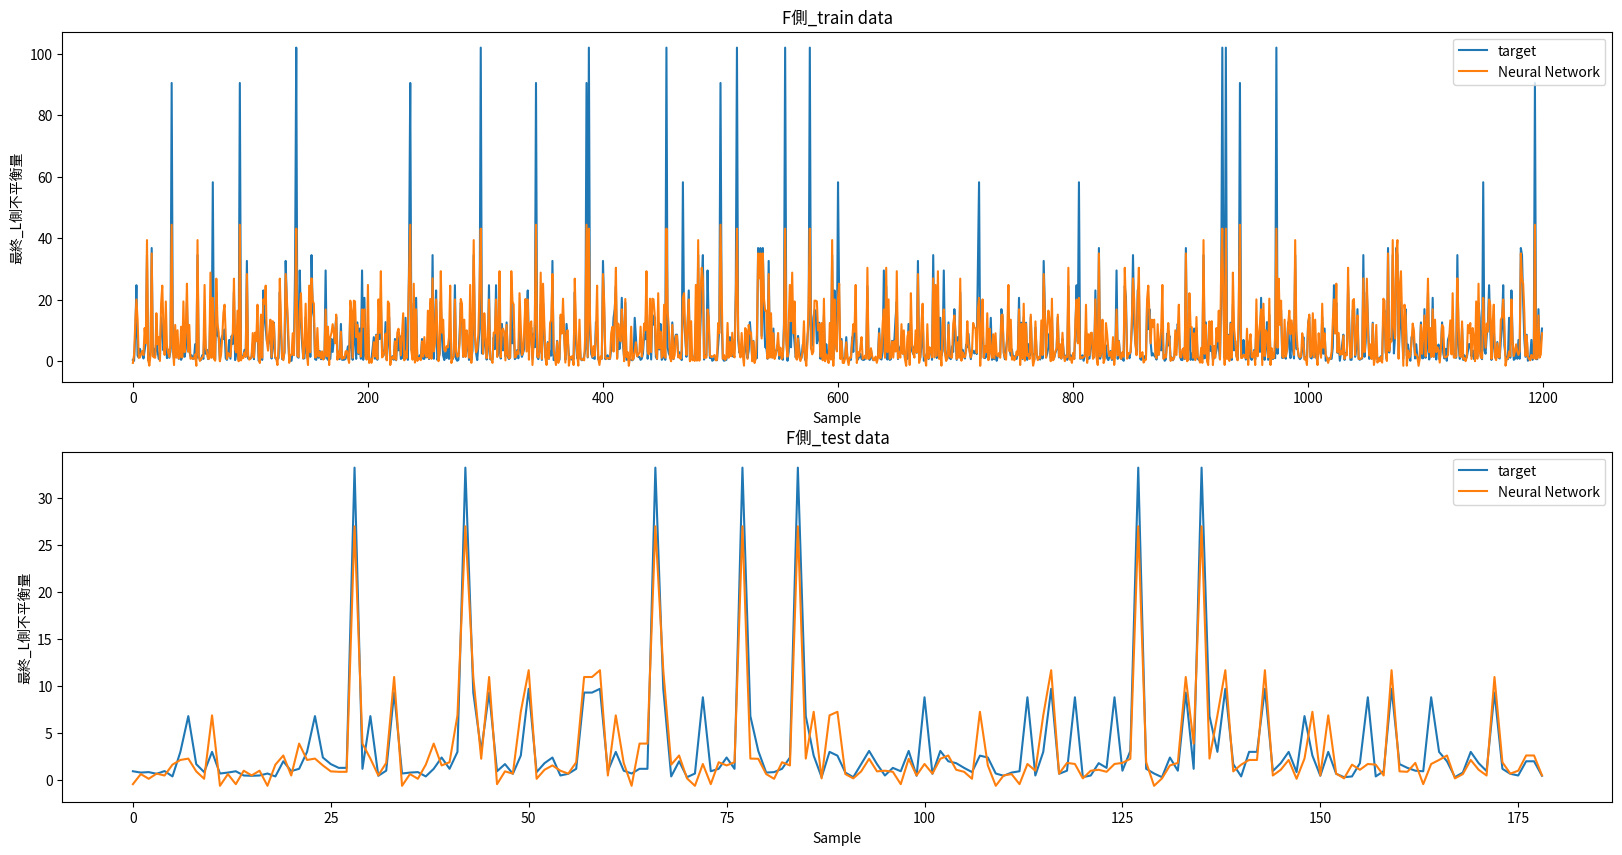

In [23]:
pred_trains_clone = pd.DataFrame()
pred_test_clone = pd.DataFrame()
for _ in range(11):
    pred_trains_clone = pd.concat([pred_trains_clone, pred_trains], ignore_index = True)
for _ in range(7):
    pred_test_clone = pd.concat([pred_test_clone, pred_tests], ignore_index = True)
pred_trains_clone = pred_trains_clone.sample(1200, random_state = random_state).reset_index(drop = True)
pred_test_clone = pred_test_clone.sample(179, random_state = random_state).reset_index(drop = True)
pred_plot(pred_trains_clone, pred_test_clone, best_score, target_vol, model_path, side, top_score = 3)

In [24]:
pred_trains["error"] = abs(pred_trains["Neural Network"] - pred_trains["target"])
pred_trains = pred_trains.sort_values("error")
pred_trains = pred_trains.query("error <= 20")
pred_trains

,target,Linear,Linear (L2),Linear (L1),Neural Network,error
121,0.75,-1.489526,-1.948754,-1.633931,0.726549,0.023451
14,1.20,0.739215,0.570436,1.218252,1.137691,0.062309
3,1.40,-1.612438,-1.333499,2.121625,1.466592,0.066592
97,1.30,2.887782,2.499408,3.303097,1.218654,0.081346
33,0.76,7.382209,7.058323,3.918047,0.846714,0.086714
...,...,...,...,...,...,...
117,4.50,9.531771,10.006812,10.172913,16.425063,11.925063
43,12.50,23.038043,23.037820,19.329332,24.789310,12.289310
32,29.50,16.467117,16.390474,16.074272,16.812119,12.687881
99,5.80,14.252151,14.473188,13.288079,19.424526,13.624526


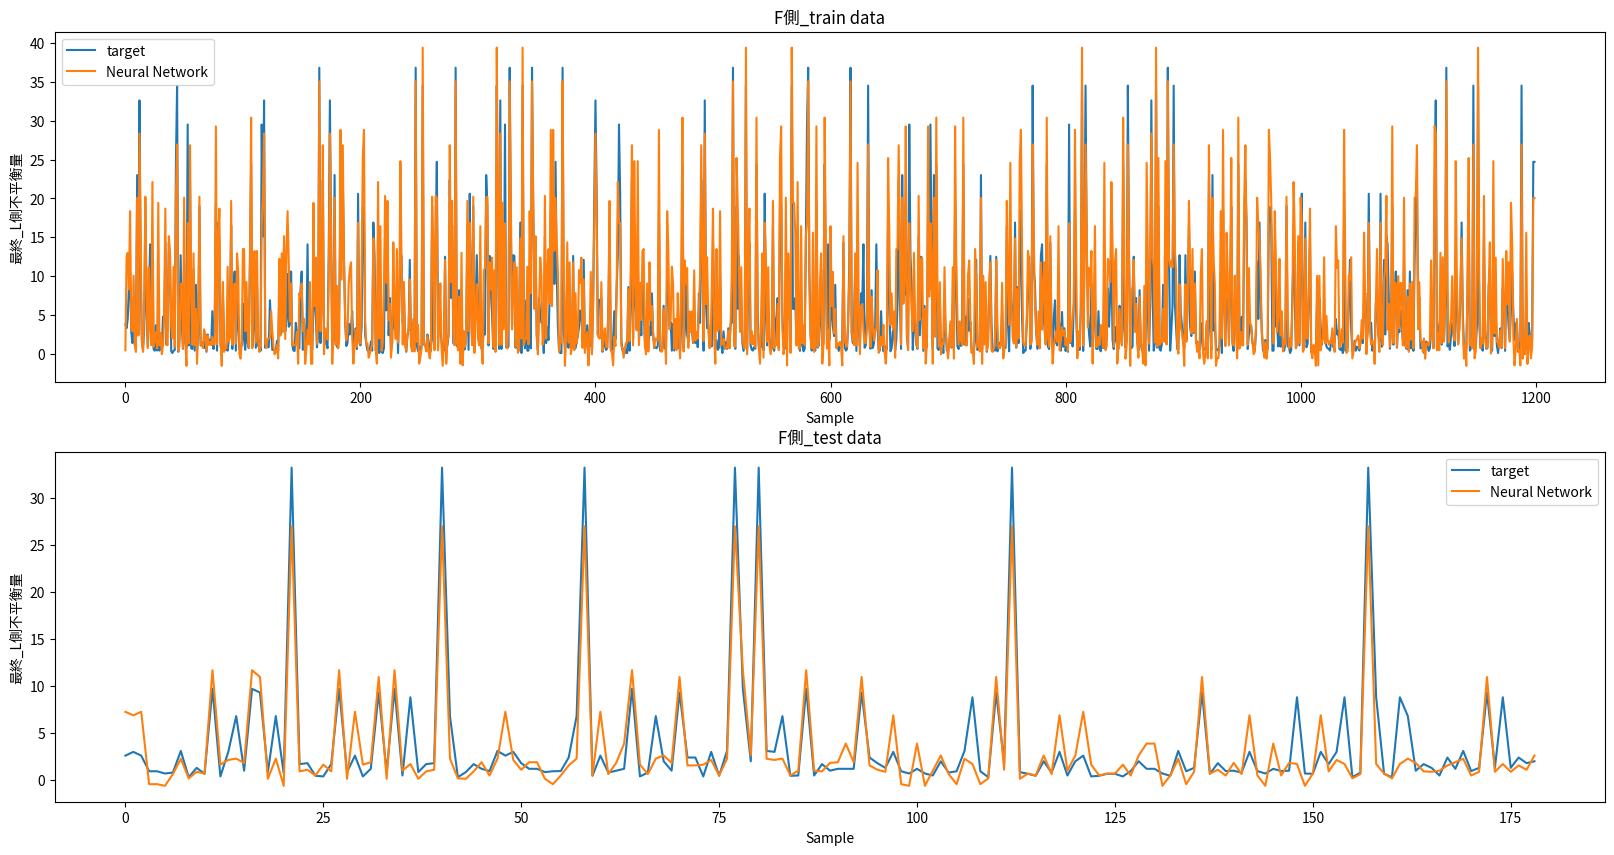

In [25]:
pred_trains_clone = pd.DataFrame()
pred_test_clone = pd.DataFrame()
for _ in range(11):
    pred_trains_clone = pd.concat([pred_trains_clone, pred_trains], ignore_index = True)
for _ in range(7):
    pred_test_clone = pd.concat([pred_test_clone, pred_tests], ignore_index = True)
pred_trains_clone = pred_trains_clone.sample(1200, random_state = random_state).reset_index(drop = True)
pred_test_clone = pred_test_clone.sample(179, random_state = random_state).reset_index(drop = True)
pred_plot(pred_trains_clone, pred_test_clone, best_score, target_vol, model_path, side, top_score = 3)